**Autor:** Hermino Barbosa de Freitas Júnior <br>
**E-mail:** herminojunior@gmail.com

### Importações e Bibliotecas utilizadas

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

URI_TREINO = "https://github.com/tgcsantos/quaretenadados/blob/master/DADOS_TREINO.csv?raw=true"
URI_TESTE = "https://github.com/tgcsantos/quaretenadados/raw/master/DADOS_TESTE.csv"
URI_DESAFIOQT = "https://github.com/tgcsantos/quaretenadados/raw/master/DESAFIOQT.csv"

dados_treino = pd.read_csv(URI_TREINO)
dados_teste = pd.read_csv(URI_TESTE)
dados_desafioqt = pd.read_csv(URI_DESAFIOQT)

erro_treino = "Erro ao carregar dados de treino"
erro_teste = "Erro ao carregar dados de teste"
erro_desafioqt = "Erro ao carregar dados de submissão"

assert dados_treino.shape == (150000, 5), erro_treino
assert dados_teste.shape == (20000, 5), erro_teste
assert dados_desafioqt.shape == (10000, 5), erro_desafioqt

## Organizando os dados

Nessa etapa foram removidos os zeros

In [114]:
search = 'NU_NOTA_CN==0&NU_NOTA_CH==0&NU_NOTA_LC==0&NU_NOTA_MT==0&NU_NOTA_REDACAO==0'
indices_zeros_treino = dados_treino.query(search).index
indices_zeros_teste = dados_teste.query(search).index

dados_treino.drop(indices_zeros_treino, axis=0, inplace=True)
dados_teste.drop(indices_zeros_teste, axis=0, inplace=True)

Visualizando um exemplo dos dados de treino

In [116]:
dados_treino.sample(5)

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
122905,408.0,561.2,477.4,393.8,480.0
14763,505.8,636.0,444.0,651.2,480.0
82820,663.8,638.7,589.3,689.6,680.0
59646,545.8,635.0,568.2,664.5,500.0
127554,553.2,573.0,459.1,540.2,560.0


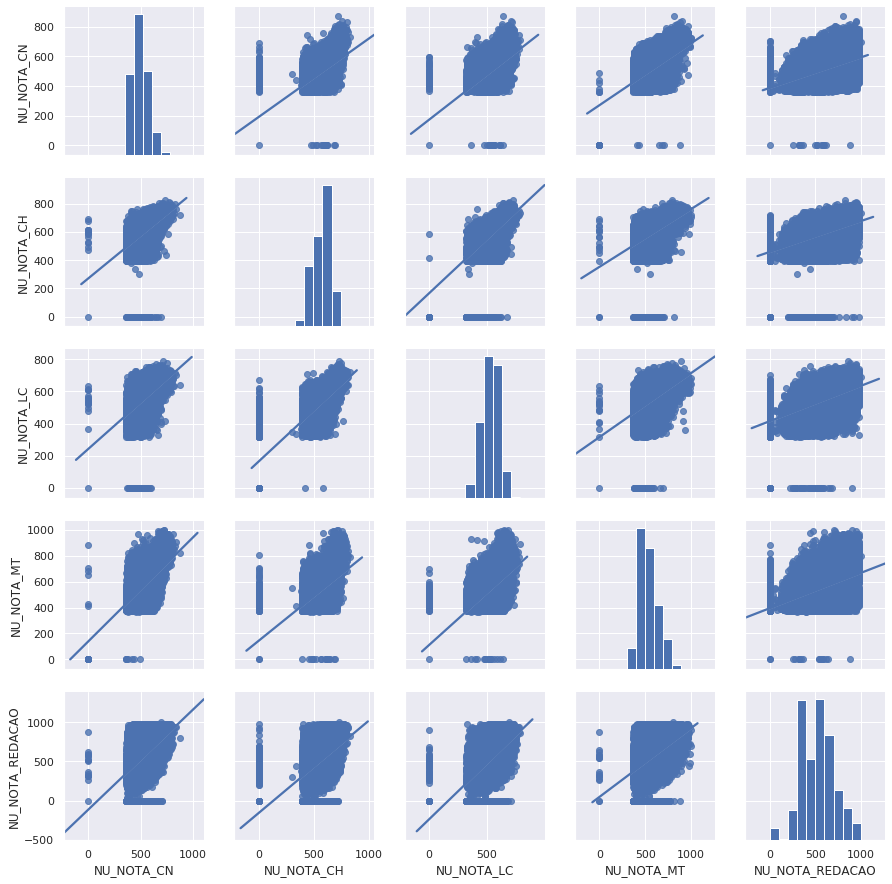

In [117]:
sns.set(color_codes=True)
ax = sns.pairplot(dados_treino, kind='reg')

Divisão dos dados de treino e teste

In [118]:
label = 'NU_NOTA_LC'
features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

X_train = dados_treino[features].to_numpy()
y_train = dados_treino[label].to_numpy()
X_test = dados_teste[features].to_numpy()
y_test = dados_teste[label].to_numpy()

### Gradient Tree Bosting Regressor 

In [119]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train, y_train)

erros = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_stimators = np.argmin(erros)

gbrt = GradientBoostingRegressor(n_estimators=bst_n_stimators)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Minha avaliação nos dados de teste foi de {mse}")

Minha avaliação nos dados de teste foi de 2046.5446141457326


Plotando resultado do Gradiente Tree Boosting

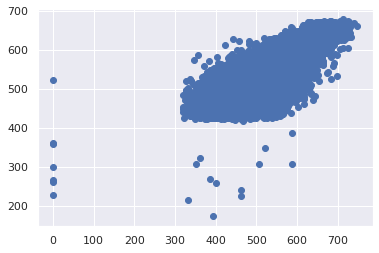

In [120]:
plt.scatter(y_test, y_pred);
plt.show()

## Usando Random Search

In [97]:
params = {
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'max_depth': np.linspace(1, 32, 32, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features': ['auto', 'sqrt', 'log2', None],
}

rscv = RandomizedSearchCV(gbrt, params, cv=10, verbose=2, n_jobs=-1, n_iter=100)
rscv.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
/home/hermino/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 41.4min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                           

Melhores parametros

In [98]:
rscv.best_params_

{'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_features': 'auto',
 'max_depth': 18.0,
 'learning_rate': 0.25}

In [105]:
y_pred = rscv.predict(X_test)
print('MSE: %f' % mean_squared_error(y_test, y_pred))

MSE: 2105.336155


Plotando resultados do Random Search

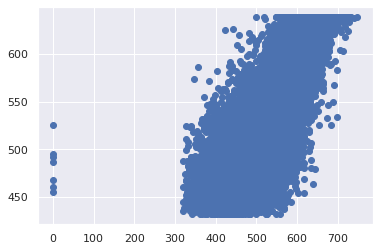

In [103]:
plt.scatter(y_test, y_pred);
plt.show()

### Armazenando Predição

In [122]:
#Foi usado o Gradiente Tree Boosting sem ajuste de hiperparametros
X_desafioqt = dados_desafioqt[features].to_numpy()
predicao_desafioqt = gbrt.predict(X_desafioqt)

desafio_df = pd.DataFrame(dados_desafioqt.ID)
desafio_df[label] = predicao_desafioqt

#NÃO TROCAR O NOME DO ARQUIVO DE SAÍDA (PREDICAO_DESAFIO)
desafio_df.to_csv('PREDICAO_DESAFIOQT.csv', index=False) 

In [123]:
predicao_desafioqt

array([499.65716106, 582.996525  , 518.44715835, ..., 527.96175044,
       576.76662297, 499.96217162])